## Calculate the similarity between distribution of landscape metrics of input training images and test image

This code was used for the publication:
1. Gevaert, C.M. & Belgiu, M. (2022) Assessing the generalization capability of deep learning networks for aerial image classification using landscape metrics. *International Journal of Applied Earth Observation and Geoinformation* [doi: 10.1016/j.jag.2022.103054](https://doi.org/10.1016/j.jag.2022.103054)
The calculation of Landscape metrics was done with the Fragstats software, and the F1-score can be obtained through various deep learning models. The code presented here is the novel similarity metric describedc in section 2.6 of the publication.

### Required inputs:
'Landscape_Metrics_kMeans.csv' - a .csv file with the input data. The first column gives the name of the training image, each subsequent column provides the landscape metrics, and the final column(s) provide the F1 scores that was obtained for that image by the trained classifier. The example data here presents the results of the k-means clustering with two classes i.e. it duplicates the results of the Clusting --> k=2 column in Table 2 of the publication above.



In [2]:
# import dependencies
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns

In [3]:
# Custom functions to calculate the similarity
def get_sigma(var_array, K):
    # will get a matrix with the distances between values of all values for input tiles
    # column_stack is only because the tool uses x,y coordinates and we only have one...
    z=np.column_stack((var_array,np.zeros(len(var_array))))
    Ds = cdist(z,z)
    #print('distance matrix:')
    #print(Ds)
    # all distances are double in the matrix, and we are not interested in distance to self
    # so select only the upper triangle distances
    Ds = Ds[np.triu_indices_from(Ds, k=1)]
    # sort the values 
    Ds.sort()
    #print('sorted distance values:')
    #print(Ds)
    # calculate localized Sigma
    sigma = Ds[K-1] # -1 because python starts indices at 0
    return sigma

def get_similarity(var_array, test_var, sigma, k=10):
    # get difference between all input tiles & testing tile for specific variable
    dists = [n - test_var for n in var_array]
    #print(dists)
    # define similarity gaussian distance (using RBF kernel and optimal sigma defined earlier
    simil = [np.exp((-n**2)/sigma) for n in dists]
    #print(simil)
    # sort, descending because highest similarity first
    simil.sort(reverse = True)
    #print(simil)
    # normalize the similarity of the K nearest neighbours.
    S = sum(simil[0:k-1])/k
    return S

def loop_similarity(trainIdx, suffix, var, varList, data, results, K):
    # trainVar will contain the values of said landscape matrix for the input training images, according to given indices
    trainVar = data.loc[trainIdx, varList[var]]
    trainVar = trainVar.values.tolist()
    # testVar will contain indices of all images for which similarity is to be calculated. Here assuming all in list
    testVar = data.loc[:, varList[var]] # possibly replace : with e.g. list(range(30)) or idx of testing image
    testVar = testVar.values.tolist()
    # find the distance between all points in input set using RBF Kernel as a similarity metric
    # Step 1: define the optimal sigma for the RBF kernel
    sigma = get_sigma(trainVar,K)
    # Step 2: calculate similarity all images to distribution training set images
    Similarities = [get_similarity(trainVar, testVar[i], sigma) for i in list(range(30))]
    # Step 3: save results in dataframe
    results[varList[var] + suffix] = Similarities
    return results

In [4]:
# set parameters here:

# input csv file
filename = 'Landscape_Metrics_kMeans.csv'

# set number of nearest neighbours used to calculate the optimal sigma
K = 7

In [5]:
# load and visualize input data
data = pd.read_csv(filename)
data

,﻿LID,NP,PD,ED,LSI,AREA_AM,SHAPE_MN,SHAPE_SD,FRAC_MN,FRAC_SD,...,SHDI,SIDI,MSIDI,SHEI,F1_ACC,F1_DAR,F1_ZNZ,F1_S1,F1_S2,F1_S3
0,ACC_01,32205,514868.0232,13803.1633,87.3043,2.6234,1.2577,0.7927,2.859780e+12,1.668980e+14,...,0.6421,0.4498,0.5976,0.9264,0.88,0.66,0.43,0.54,0.20,0.86
1,ACC_02,29708,475708.4907,12303.9212,77.8687,2.9449,1.2535,0.7224,1.403240e+12,1.021090e+14,...,0.6134,0.4224,0.5489,0.8850,0.87,0.53,0.32,0.40,0.10,0.87
2,ACC_03,25835,413029.5103,11925.8974,75.5667,2.9227,1.2816,0.7623,1.826790e+12,9.975120e+13,...,0.6175,0.4263,0.5557,0.8909,0.88,0.67,0.49,0.53,0.29,0.86
3,ACC_04,46455,742685.7326,16101.2764,101.6732,1.0671,1.2022,0.7898,1.370160e+12,1.063690e+14,...,0.6927,0.4995,0.6922,0.9993,0.83,0.66,0.68,0.53,0.74,0.70
4,ACC_05,47981,767082.2115,15687.7673,99.0878,2.2276,1.2108,0.7610,1.811660e+12,1.293540e+14,...,0.6671,0.4742,0.6428,0.9624,0.84,0.69,0.70,0.64,0.72,0.71
5,ACC_06,47974,766970.3010,16310.7568,102.9830,1.6763,1.2175,0.8237,1.756360e+12,1.283290e+14,...,0.6844,0.4913,0.6758,0.9874,0.84,0.67,0.71,0.65,0.72,0.66
6,ACC_07,32719,523085.4479,13145.2577,83.1907,1.3977,1.2364,0.8129,1.384040e+12,1.190860e+14,...,0.6914,0.4983,0.6897,0.9975,0.81,0.54,0.23,0.61,0.26,0.69
7,ACC_08,38427,614340.4294,14345.9929,90.6983,1.9771,1.2556,0.8702,1.507610e+12,1.294740e+14,...,0.6838,0.4907,0.6747,0.9865,0.80,0.57,0.34,0.66,0.19,0.67
8,ACC_09,37278,595971.1277,13764.2824,87.0612,1.3144,1.2393,0.7899,1.556410e+12,1.351570e+14,...,0.6917,0.4986,0.6903,0.9980,0.80,0.47,0.25,0.56,0.08,0.65
9,ACC_10,49056,784268.4597,19074.4334,120.2629,2.3599,1.2700,0.9487,1.567890e+12,1.258760e+14,...,0.6559,0.4632,0.6221,0.9462,0.58,0.50,0.42,0.65,0.09,0.47


In [6]:
# list row indices used for training sets
trainAcc = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
trainZnz = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
trainDar = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# select landscape metrics you wish to analyze - in this case we select all, can modify varList if you only wish to check some
varIdx = list(range(1,17))
varList = data.columns.values.tolist()
varList = [varList[i] for i in varIdx]
varList

# define output dataframe
results = pd.DataFrame()

In [7]:
# Run calculations for selected landscape metrics over different training sets
trainIdx = trainAcc
suffix = '_Acc'
for i in range(len(varIdx)):
    loop_similarity(trainIdx, suffix, i, varList, data, results, K)

trainIdx = trainZnz
suffix = '_Znz'
for i in range(len(varIdx)):
    loop_similarity(trainIdx, suffix, i, varList, data, results, K)
    
trainIdx = trainDar
suffix = '_Dar'
for i in range(len(varIdx)):
    loop_similarity(trainIdx, suffix, i, varList, data, results, K)
    
compare = pd.concat([results, data[['F1_ACC', 'F1_DAR', 'F1_ZNZ']]], axis=1)

# optionally save output to a csv file
#results.to_csv('Similarity_results.csv')

In [8]:
# list all the similarity results
for col in results.columns:
    print(col)

 NP _Acc
 PD _Acc
 ED _Acc
 LSI _Acc
 AREA_AM _Acc
 SHAPE_MN _Acc
 SHAPE_SD _Acc
 FRAC_MN _Acc
 FRAC_SD _Acc
 CONTIG_MN _Acc
 CONTIG_SD _Acc
 CONTAG _Acc
 SHDI _Acc
 SIDI _Acc
 MSIDI _Acc
 SHEI_Acc
 NP _Znz
 PD _Znz
 ED _Znz
 LSI _Znz
 AREA_AM _Znz
 SHAPE_MN _Znz
 SHAPE_SD _Znz
 FRAC_MN _Znz
 FRAC_SD _Znz
 CONTIG_MN _Znz
 CONTIG_SD _Znz
 CONTAG _Znz
 SHDI _Znz
 SIDI _Znz
 MSIDI _Znz
 SHEI_Znz
 NP _Dar
 PD _Dar
 ED _Dar
 LSI _Dar
 AREA_AM _Dar
 SHAPE_MN _Dar
 SHAPE_SD _Dar
 FRAC_MN _Dar
 FRAC_SD _Dar
 CONTIG_MN _Dar
 CONTIG_SD _Dar
 CONTAG _Dar
 SHDI _Dar
 SIDI _Dar
 MSIDI _Dar
 SHEI_Dar


In [9]:
# Visualize the correlation between the similarity of the landscape metric and the F1-score obtained by the classifier.
NP = pd.concat([results[' NP _Acc'], results[' NP _Znz'], results[' NP _Dar']], axis=0)
PD = pd.concat([results[' PD _Acc'], results[' PD _Znz'], results[' PD _Dar']], axis=0)
ED = pd.concat([results[' ED _Acc'], results[' ED _Znz'], results[' ED _Dar']], axis=0)
LSI = pd.concat([results[' LSI _Acc'], results[' LSI _Znz'], results[' LSI _Dar']], axis=0)
AREA_AM = pd.concat([results[' AREA_AM _Acc'], results[' AREA_AM _Znz'], results[' AREA_AM _Dar']], axis=0)
SHAPE_MN = pd.concat([results[' SHAPE_MN _Acc'], results[' SHAPE_MN _Znz'], results[' SHAPE_MN _Dar']], axis=0)
SHAPE_SD = pd.concat([results[' SHAPE_SD _Acc'], results[' SHAPE_SD _Znz'], results[' SHAPE_SD _Dar']], axis=0)
FRAC_MN = pd.concat([results[' FRAC_MN _Acc'], results[' FRAC_MN _Znz'], results[' FRAC_MN _Dar']], axis=0)
FRAC_SD = pd.concat([results[' FRAC_SD _Acc'], results[' FRAC_SD _Znz'], results[' FRAC_SD _Dar']], axis=0)
CONTIG_MN = pd.concat([results[' CONTIG_MN _Acc'], results[' CONTIG_MN _Znz'], results[' CONTIG_MN _Dar']], axis=0)
CONTIG_SD = pd.concat([results[' CONTIG_SD _Acc'], results[' CONTIG_SD _Znz'], results[' CONTIG_SD _Dar']], axis=0)
CONTAG = pd.concat([results[' CONTAG _Acc'], results[' CONTAG _Znz'], results[' CONTAG _Dar']], axis=0)
SHDI = pd.concat([results[' SHDI _Acc'], results[' SHDI _Znz'], results[' SHDI _Dar']], axis=0)
SIDI = pd.concat([results[' SIDI _Acc'], results[' SIDI _Znz'], results[' SIDI _Dar']], axis=0)
MSIDI = pd.concat([results[' MSIDI _Acc'], results[' MSIDI _Znz'], results[' MSIDI _Dar']], axis=0)
SHEI = pd.concat([results[' SHEI_Acc'], results[' SHEI_Znz'], results[' SHEI_Dar']], axis=0)

F1 = pd.concat([data['F1_ACC'], data['F1_ZNZ'], data['F1_DAR']], axis=0)
total2 = pd.concat([NP, PD, ED, LSI, AREA_AM, SHAPE_MN, SHAPE_SD, FRAC_MN, FRAC_SD, CONTIG_MN, CONTIG_SD, CONTAG, SHDI, SIDI, MSIDI, SHEI, F1], axis=1)

corrMatrix = total2.corr(method='spearman')
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)
# the last column presents the correlation between the landscape metric and the F1 score, and corresponds to the results of Table 2.

/tmp/ipykernel_893/159945473.py:23: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.00,0.91,0.79,0.76,0.22,0.45,0.11,0.88,0.88,0.61,0.60,0.52,-0.02,-0.02,-0.01,-0.02,0.58
1,0.91,1.00,0.83,0.79,0.30,0.37,0.16,0.97,0.97,0.62,0.58,0.60,0.09,0.09,0.10,0.08,0.64
2,0.79,0.83,1.00,0.95,0.26,0.32,0.18,0.85,0.85,0.51,0.48,0.65,0.05,0.04,0.06,0.04,0.70
3,0.76,0.79,0.95,1.00,0.26,0.28,0.25,0.80,0.80,0.45,0.40,0.70,0.06,0.06,0.08,0.06,0.69
4,0.22,0.30,0.26,0.26,1.00,0.31,0.19,0.29,0.29,0.21,0.13,0.38,0.63,0.63,0.64,0.63,0.15
5,0.45,0.37,0.32,0.28,0.31,1.00,0.33,0.37,0.37,0.46,0.33,0.24,0.08,0.09,0.11,0.09,0.11
6,0.11,0.16,0.18,0.25,0.19,0.33,1.00,0.13,0.13,0.10,-0.14,0.38,0.06,0.06,0.07,0.07,0.25
7,0.88,0.97,0.85,0.80,0.29,0.37,0.13,1.00,1.00,0.61,0.59,0.60,0.07,0.07,0.08,0.07,0.68
8,0.88,0.97,0.85,0.80,0.29,0.37,0.13,1.00,1.00,0.61,0.59,0.60,0.07,0.07,0.08,0.07,0.68
9,0.61,0.62,0.51,0.45,0.21,0.46,0.10,0.61,0.61,1.00,0.80,0.24,-0.12,-0.12,-0.10,-0.12,0.23


In [10]:
#corrMatrix = total2.corr(method='spearman')
#corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

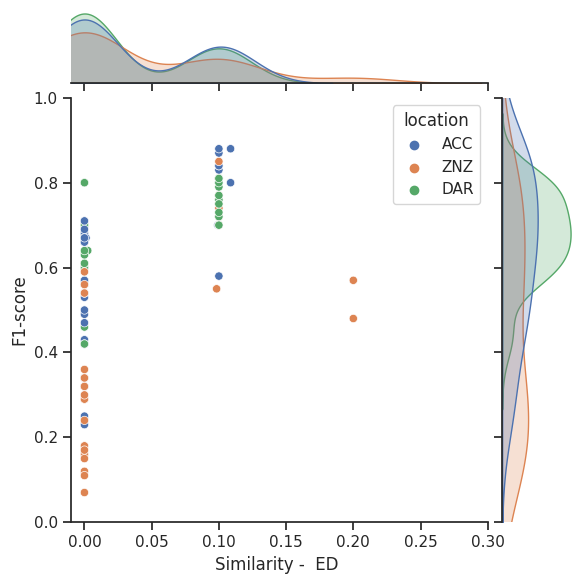

In [16]:
# Visualize the results for a landscape metric, e.g. ED as in Figure 6b of the publication
#total2 = total2.reset_index()
labels = ["ACC".format() for i in range(0, 10)] + ["ZNZ".format() for i in range(0, 10)] + ["DAR".format() for i in range(0, 10)] + ["ACC".format() for i in range(0, 10)] + ["ZNZ".format() for i in range(0, 10)] + ["DAR".format() for i in range(0, 10)] + ["ACC".format() for i in range(0, 10)] + ["ZNZ".format() for i in range(0, 10)] + ["DAR".format() for i in range(0, 10)]
total2["location"] = labels

sns.set_theme(style='ticks')

# select index nr of the LM metric you want to show,  here 2 refers to the ED landscape metric (see VarList) and 16 refers to the F1 score.
g = sns.jointplot(data=total2, x=2, y=16, hue="location", xlim=[-0.01,0.3], ylim=[0,1])
g.set_axis_labels(xlabel = 'Similarity - {}'.format(varList[2]),ylabel = "F1-score")

# optionally save the figure
#g.savefig("LMkmeans2_ED.png")
#sns.jointplot(3, 16, data=total2, hue="location", kind="hist") #xlim=[0,0.1]
#sns.jointplot(3, 16, data=total2, kind="hist", joint_kws=dict(bins=20))
